## Imports

In [1]:
from keras import losses
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Reshape, UpSampling2D, Dense
from keras.layers.merge import concatenate
from keras.layers import Flatten
from keras.optimizers import Adam
import pandas as pd
from scipy.misc import imresize
from keras.layers import concatenate
from keras.utils import np_utils
import os
import numpy as np
import random
import cv2
import networkx as nx
import pylab as plt

Using TensorFlow backend.


## Functions For Datagen and Triplet Generation

In [2]:
TRAINING_IMAGE_DIR = "unseen-dataset/TrainingSet/"
VALIDATION_IMAGE_DIR = "unseen-dataset/ValidationSet/"

def load_image(image_name):
    if image_name not in image_cache:
        image = cv2.imread(os.path.join(TRAINING_IMAGE_DIR,image_name),0)
        if image is None:
            image = cv2.imread(os.path.join(VALIDATION_IMAGE_DIR,image_name),0)
        image = image.reshape((64,64,1))
        image_cache[image_name] = image
    return image_cache[image_name]

def generate_image_triples_batch(image_triples, batch_size):
    while True:
        # loop once per epoch
        indices = np.random.randint(0,len(image_triples),batch_size)
        shuffled_triples = [image_triples[ix] for ix in indices]
        num_batches = len(shuffled_triples) // batch_size
        for bid in range(num_batches):
            # loop once per batch
            images_left, images_right, labels = [], [], []
            batch = shuffled_triples[bid * batch_size : (bid + 1) * batch_size]
            for i in range(batch_size):
                lhs, rhs, label = batch[i]
                images_left.append(load_image(lhs))
                images_right.append(load_image(rhs))              
                labels.append(label)
            Xlhs = np.array(images_left)
            Xrhs = np.array(images_right)
            Y = np_utils.to_categorical(np.array(labels), num_classes=2)
            yield ([Xlhs, Xrhs], Y)

## Model Creation and Running

In [3]:
training_data = pd.read_csv("unseen-dataset/dataset_unseen_training_siamese.csv")
validation_data = pd.read_csv("unseen-dataset/dataset_unseen_validation_siamese.csv")
image_cache = {}

training_data = training_data.drop('Unnamed: 0',1)
validation_data = validation_data.drop('Unnamed: 0',1)
training_data
imDim = 64
input_shape  = (imDim,imDim,1)
inp_img = Input(shape = (imDim,imDim,1), name = 'ImageInput')
model = inp_img
batchSize = 64

model = Conv2D(32,kernel_size=(3, 3),activation='relu',input_shape=input_shape,padding='valid')(model)

model = MaxPooling2D((2,2), padding='valid')(model)
model = Conv2D(64, (3, 3), activation='relu',padding='valid')(model)

model = MaxPooling2D((2,2),padding='valid')(model)

model = Conv2D(128, (3, 3), activation='relu',padding='valid')(model)
model = MaxPooling2D((2,2),padding='valid')(model)

model = Conv2D(256, (1, 1), activation='relu',padding='valid')(model)
model = MaxPooling2D((2,2),padding='valid')(model)

model = Conv2D(64, (1, 1), activation='relu',padding='valid')(model)

model = Flatten()(model)

feat = Model(inputs=[inp_img], outputs=[model],name = 'Feat_Model')
feat.summary()

left_img = Input(shape = (imDim,imDim,1), name = 'left_img')
right_img = Input(shape = (imDim,imDim,1), name = 'right_img')

left_feats = feat(left_img)
right_feats = feat(right_img)

merged_feats = concatenate([left_feats, right_feats], name = 'concat_feats')
merged_feats = Dense(1024, activation = 'linear')(merged_feats)
merged_feats = BatchNormalization()(merged_feats)
merged_feats = Activation('relu')(merged_feats)
merged_feats = Dense(4, activation = 'linear')(merged_feats)
merged_feats = BatchNormalization()(merged_feats)
merged_feats = Activation('relu')(merged_feats)
merged_feats = Dense(2, activation = 'sigmoid')(merged_feats)
similarity_model = Model(inputs = [left_img, right_img], outputs = [merged_feats], name = 'Similarity_Model')
similarity_model.compile(loss=losses.categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
similarity_model.summary()

training_datagen = generate_image_triples_batch(training_data.values,batchSize)
validation_datagen = generate_image_triples_batch(validation_data.values,batchSize)

history = similarity_model.fit_generator(training_datagen,steps_per_epoch=len(training_data)/batchSize, epochs=10,validation_data=validation_datagen,validation_steps=len(validation_data)/batchSize)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_

## Inference Plotting

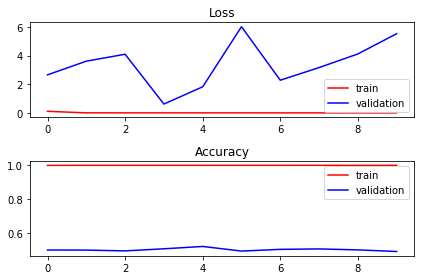

In [4]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()